In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

In [2]:
DATA_PATH = './digits_data'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_set = datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=False)
test_set = datasets.MNIST(root=DATA_PATH, train=False, transform=trans, download=False)

In [3]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = train_set.classes
print('Total train images: {}, number of batches: {}'.format(len(train_loader)*batch_size,
                                                             len(train_loader)))
print('Total test images: {}, number of batches: {}'.format(len(test_loader)*batch_size,
                                                            len(test_loader)))
print('Class names:', class_names)

Total train images: 60000, number of batches: 600
Total test images: 10000, number of batches: 100
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


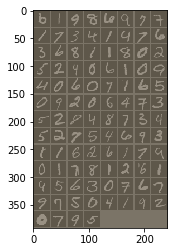

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [6]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_loader)*batch_size, 'val': len(test_loader)*batch_size}

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = outputs.to(device)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
class ValerioNet(nn.Module):

    def __init__(self, num_classes: int = 10) -> None:
        super(ValerioNet, self).__init__()
        #input (1, 28, 28)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=3, padding=1),
            #output (64, 9, 9)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #output (64, 4, 4)
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            #output (192, 6, 6)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #ouput (196, 3, 3)
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            #output (384, 3, 3)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            #output (256, 3, 3)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            #output (256, 3, 3)
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1096),
            nn.ReLU(inplace=True),
            nn.Linear(1096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output
    
my_net = ValerioNet()

In [10]:
if torch.cuda.is_available():
    my_net.cuda()

In [11]:
random_data = torch.rand((1, 1, 28, 28))

result = my_net(random_data.to(device))
print (result)

tensor([[-2.2920, -2.3134, -2.2803, -2.3323, -2.3323, -2.2796, -2.2785, -2.3068,
         -2.2923, -2.3203]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [51]:
'''mnist_alexnet = models.alexnet(pretrained=True)

mnist_alexnet.features[0] = nn.Conv2d(1, 64, 7, stride=4, padding=2)
mnist_alexnet.classifier[-1] = nn.Linear(4096, 10)



mnist_alexnet = mnist_alexnet.to(device)'''

In [12]:
epoches=10
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(my_net.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

my_net = train_model(my_net,
                     criterion,
                     optimizer_ft,
                     exp_lr_scheduler,
                     num_epochs=epoches)

Epoch 0/9
----------
train Loss: 2.3015 Acc: 0.1116
val Loss: 2.3010 Acc: 0.1135

Epoch 1/9
----------
train Loss: 2.3010 Acc: 0.1128
val Loss: 2.2995 Acc: 0.1135

Epoch 2/9
----------
train Loss: 2.0098 Acc: 0.2213
val Loss: 1.3264 Acc: 0.4398

Epoch 3/9
----------
train Loss: 0.7594 Acc: 0.7084
val Loss: 0.1920 Acc: 0.9468

Epoch 4/9
----------
train Loss: 0.1723 Acc: 0.9508
val Loss: 0.1083 Acc: 0.9677

Epoch 5/9
----------
train Loss: 0.1042 Acc: 0.9702
val Loss: 0.0698 Acc: 0.9813

Epoch 6/9
----------
train Loss: 0.0741 Acc: 0.9787
val Loss: 0.0680 Acc: 0.9816

Epoch 7/9
----------
train Loss: 0.0376 Acc: 0.9899
val Loss: 0.0550 Acc: 0.9842

Epoch 8/9
----------
train Loss: 0.0323 Acc: 0.9915
val Loss: 0.0529 Acc: 0.9849

Epoch 9/9
----------
train Loss: 0.0293 Acc: 0.9920
val Loss: 0.0540 Acc: 0.9857

Training complete in 2m 48s
Best val Acc: 0.985700


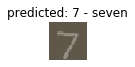

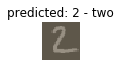

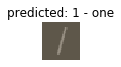

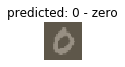

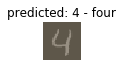

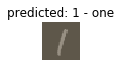

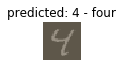

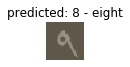

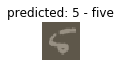

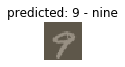

In [13]:
visualize_model(my_net)